In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem, ttest_ind, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict

from matplotlib.patches import Rectangle, Patch
from matplotlib.colors import ListedColormap, BoundaryNorm

In [5]:
import proteomics_functions as prot_fun

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

# All species

In [17]:
df_master = pd.read_csv('./generated_tables/df_master_dda_with_bare_properties.csv')
df_plot = df_master[['name', 'cq_g12', 'cq_eluate', 'xq_g12', 'xq_eluate', 'hq_g12', 'hq_eluate']].copy()

# Set name as the index (good but unnecessary for this plot)
for i, cont in df_plot.iterrows():
    name = cont['name']
    df_plot.at[i, 'name'] = name[:1].upper() + name[1:-21]
df_plot.set_index('name', inplace=True)

# Map presence to [0, 0.5, 1] as a color indicator
resins = ['cq', 'xq', 'hq']
for resin in resins:
    df_plot[f'{resin}_g12'] = df_plot[f'{resin}_g12'].map({False:0, True:1})
    df_plot[f'{resin}_eluate'] = df_plot[f'{resin}_eluate'].map({False:0, True:0.5})
    
# Set column names
df_plot.columns = ['Capto Q - End of FT', 'Capto Q - Adsorbate', 'Poros XQ - End of FT', 'Poros XQ - Adsorbate', 'Poros 50 HQ - End of FT', 'Poros 50 HQ - Adsorbate']

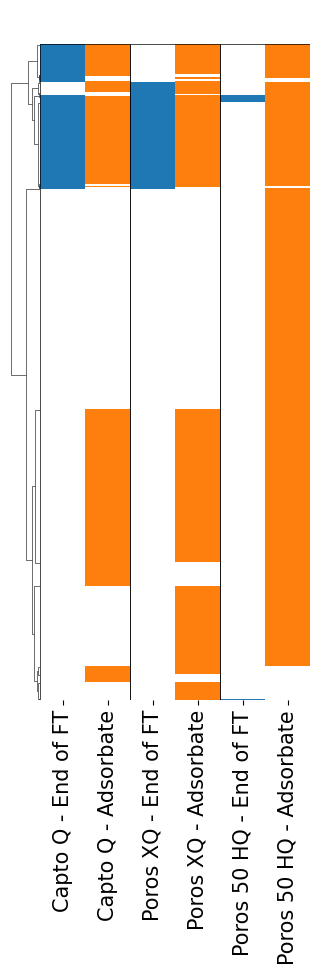

In [43]:
cmap_cluster = matplotlib.colors.ListedColormap(['white', 'tab:orange', 'tab:blue'])
norm_cluster = BoundaryNorm([0, 0.25, 0.75, 1], cmap_cluster.N)

ax = sns.clustermap(df_plot, cmap=cmap_cluster, norm=norm_cluster, method='ward', cbar_pos=None, 
                    dendrogram_ratio=(0.1, 0.05), figsize=(3.5, 9), yticklabels=False, col_cluster=False)

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=90, ha='right', va='center', rotation_mode='anchor', fontsize=15)
real_ax.set_ylabel(None)

# # Rectangles
heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((0, 0), 2, len(df_plot), fill=False, edgecolor='black', lw=0.5))
r = heat.add_patch(Rectangle((2, 0), 2, len(df_plot), fill=False, edgecolor='black', lw=0.5))
r = heat.add_patch(Rectangle((4, 0), 2, len(df_plot), fill=False, edgecolor='black', lw=0.5))

ax.savefig(f'./images/4_clustermap_all.png', dpi=300, bbox_inches='tight')

# DTR species

In [70]:
df_dtr = pd.read_csv('./generated_tables/difficult_to_remove_reviewed.csv')

papers = ['Biophorum DTR', 'Biophorum high-risk', 'Levy 2014 - Association', 'Aboulaich 2014 - Association', 'Zhang 2016 - Pro A', 
          'Levy 2016 - Coelution', 'Molden 2021 - 29 DS', 'Falkenberg 2019 - 6 DS', 'Kreimer 2017 - 1 DS']

df_dtr.fillna(value=False, inplace=True)

for i, cont in df_dtr.iterrows():
    for paper in papers:
        if cont[paper]:
            df_dtr.at[i, paper] = True
        else:
            pass
        
for paper in papers:
    df_dtr[paper] = df_dtr[paper].astype(bool, copy=False)
    
# Set name as the index (good but unnecessary for this plot)
for i, cont in df_dtr.iterrows():
    name = cont['name']
    df_dtr.at[i, 'name'] = name[:1].upper() + name[1:-21]
df_dtr.set_index('name', inplace=True)

for i, paper in enumerate(papers):
    if i == 0:
        row_colors = prot_fun.map_binary_colorbar(df_dtr[paper], color=f'C{i+2}')
    elif i == 8:
        row_colors = prot_fun.map_binary_colorbar(df_dtr[paper], color='magenta', row_colors=row_colors)
    else:
        row_colors = prot_fun.map_binary_colorbar(df_dtr[paper], color=f'C{i+2}', row_colors=row_colors)

In [71]:
df_plot = df_dtr[['cq_g12', 'cq_eluate', 'xq_g12', 'xq_eluate', 'hq_g12', 'hq_eluate']].copy()

# Map presence to [0, 0.5, 1] as a color indicator
resins = ['cq', 'xq', 'hq']
for resin in resins:
    df_plot[f'{resin}_g12'] = df_plot[f'{resin}_g12'].map({False:0, True:1})
    df_plot[f'{resin}_eluate'] = df_plot[f'{resin}_eluate'].map({False:0, True:0.5})
    
# Set column names
df_plot.rename(columns={'cq_g12':'Capto Q - End of FT', 
                        'cq_eluate':'Capto Q - Adsorbate', 
                        'xq_g12':'Poros XQ - End of FT', 
                        'xq_eluate':'Poros XQ - Adsorbate', 
                        'hq_g12':'Poros 50 HQ - End of FT', 
                        'hq_eluate':'Poros 50 HQ - Adsorbate'}, inplace=True) 

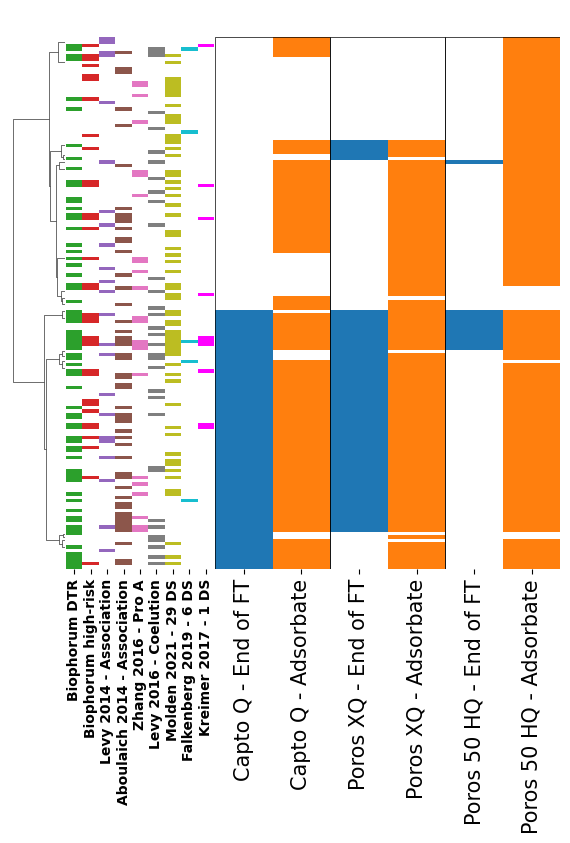

In [83]:
cmap_cluster = matplotlib.colors.ListedColormap(['white', 'tab:orange', 'tab:blue'])
norm_cluster = BoundaryNorm([0, 0.25, 0.75, 1], cmap_cluster.N)

ax = sns.clustermap(df_plot, cmap=cmap_cluster, norm=norm_cluster, method='ward', cbar_pos=None, 
                    dendrogram_ratio=(0.1, 0.05), figsize=(6, 8), yticklabels=False, col_cluster=False, row_colors=row_colors)

fontsize = 15
rotation = 90

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

# Set annotation row color label 
ax_row_colors = ax.ax_row_colors
_ = ax_row_colors.set_xticklabels(ax_row_colors.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=10, weight='bold')

# # Rectangles
heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((0, 0), 2, len(df_plot), fill=False, edgecolor='black', lw=0.5))
r = heat.add_patch(Rectangle((2, 0), 2, len(df_plot), fill=False, edgecolor='black', lw=0.5))
r = heat.add_patch(Rectangle((4, 0), 2, len(df_plot), fill=False, edgecolor='black', lw=0.5))

ax.savefig(f'./images/4_clustermap_dtr.png', dpi=300, bbox_inches='tight')

# High-risk

In [87]:
df_risk = pd.read_csv('./generated_tables/high_risk.csv')
    
# Set name as the index (good but unnecessary for this plot)
df_risk.rename(columns={'impact':'Impact'}, inplace=True)
for i, cont in df_risk.iterrows():
    name = cont['name']
    df_risk.at[i, 'name'] = name[:1].upper() + name[1:-21]
df_risk.set_index('name', inplace=True)

In [88]:
df_plot = df_risk[['cq_g12', 'cq_eluate', 'xq_g12', 'xq_eluate', 'hq_g12', 'hq_eluate']].copy()

# Map presence to [0, 0.5, 1] as a color indicator
resins = ['cq', 'xq', 'hq']
for resin in resins:
    df_plot[f'{resin}_g12'] = df_plot[f'{resin}_g12'].map({False:0, True:1})
    df_plot[f'{resin}_eluate'] = df_plot[f'{resin}_eluate'].map({False:0, True:0.5})
    
# Set column names
df_plot.rename(columns={'cq_g12':'Capto Q - End of FT', 
                        'cq_eluate':'Capto Q - Adsorbate', 
                        'xq_g12':'Poros XQ - End of FT', 
                        'xq_eluate':'Poros XQ - Adsorbate', 
                        'hq_g12':'Poros 50 HQ - End of FT', 
                        'hq_eluate':'Poros 50 HQ - Adsorbate'}, inplace=True) 

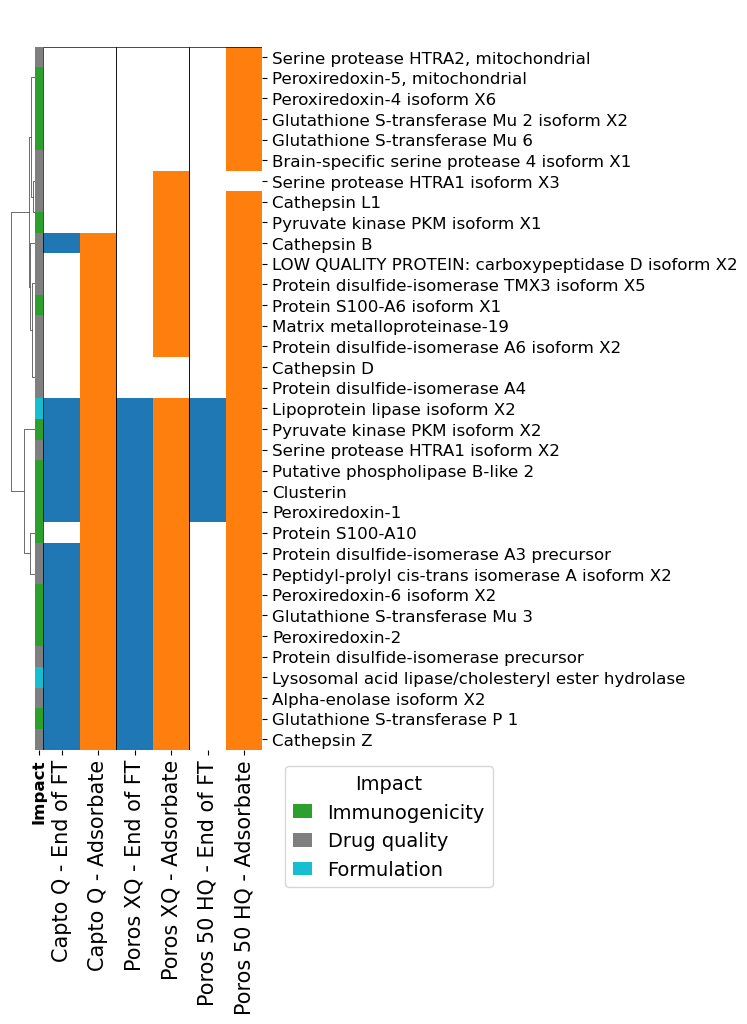

In [107]:
cmap_cluster = matplotlib.colors.ListedColormap(['white', 'tab:orange', 'tab:blue'])
norm_cluster = BoundaryNorm([0, 0.25, 0.75, 1], cmap_cluster.N)

cmap_impact = dict(zip(df_risk.Impact.unique(), ["tab:green", "tab:grey", "tab:cyan"]))
row_colors = df_risk.Impact.map(cmap_impact)

ax = sns.clustermap(df_plot, cmap=cmap_cluster, norm=norm_cluster, method='ward', cbar_pos=None, row_colors=row_colors,
                    dendrogram_ratio=(0.1, 0.05), figsize=(7, 9.5), yticklabels=True, col_cluster=False)

# Set heatmap xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=90, ha='right', va='center', rotation_mode='anchor', fontsize=15)
real_ax.set_yticklabels(heat.get_ymajorticklabels(), fontsize=12)
real_ax.set_ylabel(None)

# Add legend
handles = [Patch(facecolor=cmap_impact[name]) for name in cmap_impact]
plt.legend(handles, cmap_impact, title='Impact', bbox_to_anchor=(0.4, 0.05), bbox_transform=plt.gcf().transFigure, loc='lower left', fontsize=14, title_fontsize=14, frameon=True, handlelength=1)

# Set row color annotation label 
rotation = 90
ax_row_colors = ax.ax_row_colors
ax_row_colors.set_xticklabels(ax_row_colors.get_xmajorticklabels(), rotation=rotation, ha='right', rotation_mode='anchor', va='center', fontsize=12, weight='bold')

# # Rectangles
heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((0, 0), 2, len(df_plot), fill=False, edgecolor='black', lw=0.5))
r = heat.add_patch(Rectangle((2, 0), 2, len(df_plot), fill=False, edgecolor='black', lw=0.5))
r = heat.add_patch(Rectangle((4, 0), 2, len(df_plot), fill=False, edgecolor='black', lw=0.5))

ax.savefig(f'./images/4_clustermap_high_risk.png', dpi=300, bbox_inches='tight')